#### the goal here is to understand where sky residuals need to be taken care of.

- [we start with running specsim with base `desi` config and with longer exposure (1000s vs 100,000s).](#base-sim)
- [we then run `quickspectra` to generate spectra and see if things make sense.](#quickspectra)

Note that we currently bypass `quickquasars` and just work with `specsim` output fluxes to run `quickspectra`.

_this notebook should run on NERSC with DESI master kernel_

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord

import specsim.simulator

<a id="base-sim"></a>

In [3]:
# lets set up the simulator with the base config
import yaml

config_path = 'configs/desi.yaml'
with open(config_path, 'r') as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    
config = specsim.config.Configuration(config)
desi_base = specsim.simulator.Simulator(config, num_fibers=500, verbose=False)

In [4]:
# lets also set up the simulator with the base config with longer exposure
config_path = 'configs/desi_longer-exp.yaml'
with open(config_path, 'r') as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    
config = specsim.config.Configuration(config)
desi_base_longexp = specsim.simulator.Simulator(config, num_fibers=500, verbose=False)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/specsim/master/specsim/transform.py:593: UserWarning: Refraction model is inaccurate for altitudes below 5.0 deg.
  warnings.warn(


In [5]:
def generate_fiber_positions(sim, seed=123):
    gen = np.random.RandomState(seed)
    focal_r = (
        np.sqrt(gen.uniform(size=sim.num_fibers)) * sim.instrument.field_radius)
    phi = 2 * np.pi * gen.uniform(size=sim.num_fibers)
    return (np.vstack([np.cos(phi), np.sin(phi)]) * focal_r).T

def plot_focal_xy(sim):
    plt.scatter(sim.focal_x.to(u.mm).value, sim.focal_y.to(u.mm).value, s=10, lw=0)
    r = 1.05 * sim.instrument.field_radius.to(u.mm).value
    plt.xlim(-1.01 * r, +1.01 * r)
    plt.ylim(-1.01 * r, +1.01 * r)
    plt.gca().set_aspect('equal', 'datalim')
    plt.gca().add_artist(plt.Circle((0, 0), r, color='r', fill=False))
    plt.axis('off')

CPU times: user 1.3 ms, sys: 562 µs, total: 1.86 ms
Wall time: 1.33 ms

## simulating ... 
CPU times: user 8.07 s, sys: 5.31 s, total: 13.4 s
Wall time: 13.4 s
CPU times: user 792 ms, sys: 87.8 ms, total: 879 ms
Wall time: 879 ms


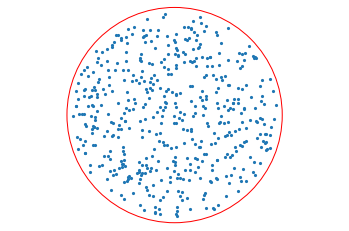

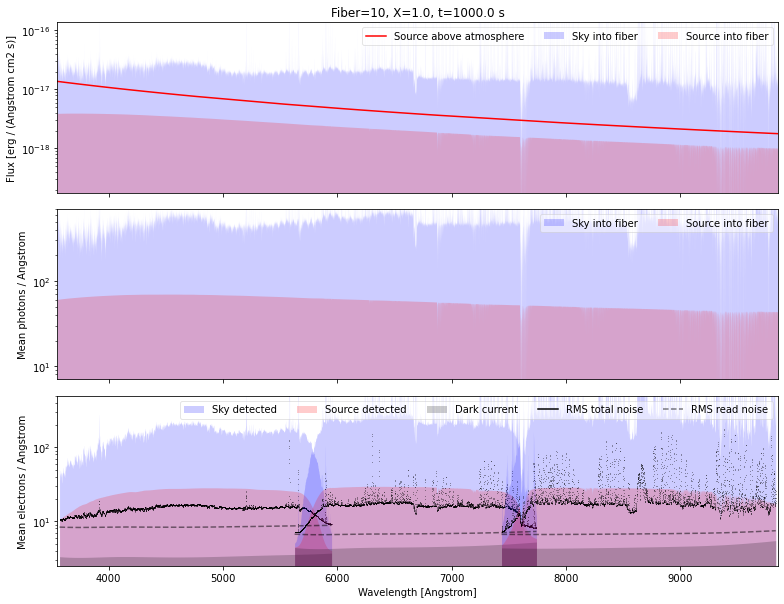

In [6]:
# generate random fiber positions
sim = desi_base
%time xy = generate_fiber_positions(sim=sim)

print('\n## simulating ... ')
%time sim.simulate(focal_positions=xy)

# plot fiber positions
plot_focal_xy(sim=sim)

%time sim.plot(fiber=10)

CPU times: user 780 µs, sys: 363 µs, total: 1.14 ms
Wall time: 792 µs

## simulating ... 
CPU times: user 7.93 s, sys: 5.47 s, total: 13.4 s
Wall time: 13.4 s
CPU times: user 529 ms, sys: 7.4 ms, total: 537 ms
Wall time: 536 ms


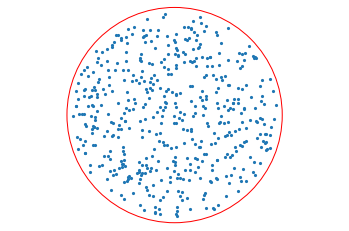

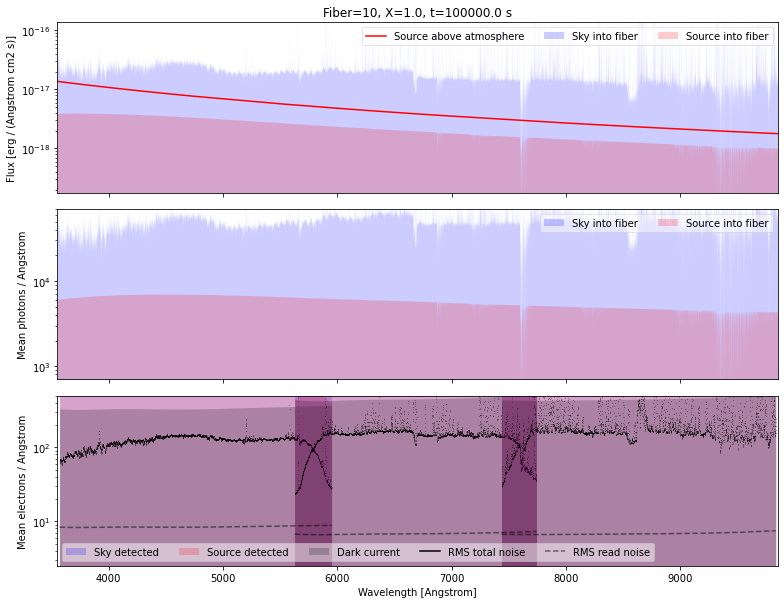

In [7]:
# generate random fiber positions
sim = desi_base_longexp
%time xy = generate_fiber_positions(sim=sim)

print('\n## simulating ... ')
%time sim.simulate(focal_positions=xy)

# plot fiber positions
plot_focal_xy(sim=sim)

%time sim.plot(fiber=10)

In [8]:
import sys
sys.path.append('../../my-utils/')
from pyutils import settings

In [9]:
desi_base.simulated.keys()

['wavelength',
 'source_flux',
 'fiberloss',
 'source_fiber_flux',
 'sky_fiber_flux',
 'num_source_photons',
 'num_sky_photons',
 'num_source_electrons_b',
 'num_sky_electrons_b',
 'num_dark_electrons_b',
 'read_noise_electrons_b',
 'num_source_electrons_r',
 'num_sky_electrons_r',
 'num_dark_electrons_r',
 'read_noise_electrons_r',
 'num_source_electrons_z',
 'num_sky_electrons_z',
 'num_dark_electrons_z',
 'read_noise_electrons_z']

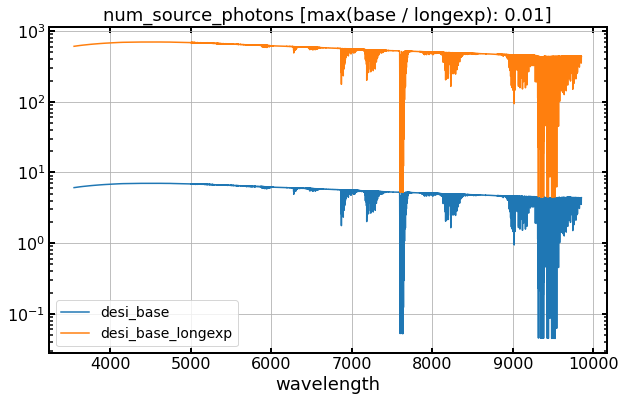

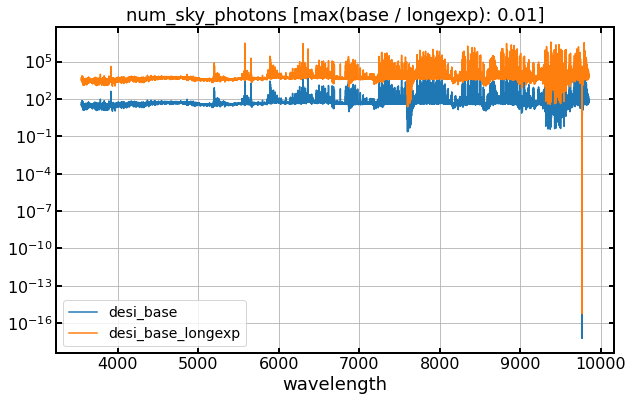

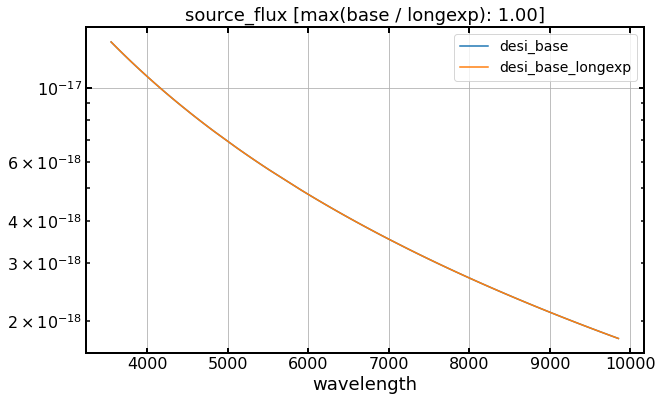

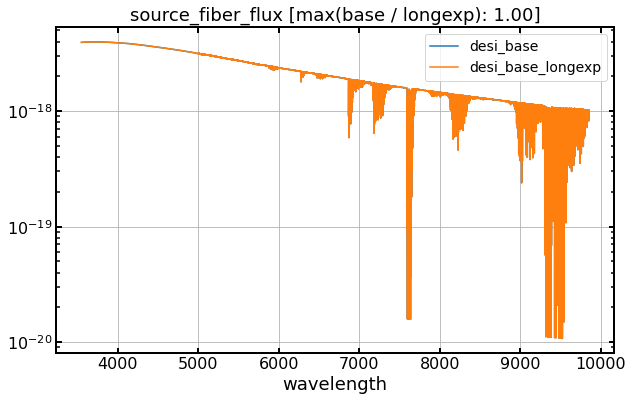

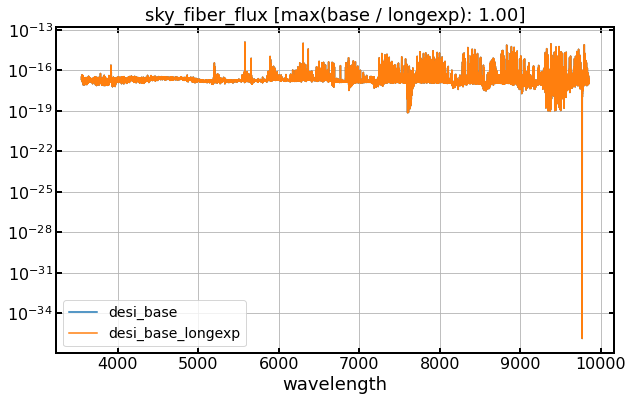

In [10]:
fiber = 10
for key in ['num_source_photons', 'num_sky_photons', 'source_flux', 'source_fiber_flux', 'sky_fiber_flux']: 
    plt.plot(desi_base.simulated['wavelength'], desi_base.simulated[key][:, fiber],
             label='desi_base')
    plt.plot(desi_base_longexp.simulated['wavelength'], desi_base_longexp.simulated[key][:, fiber],
             label='desi_base_longexp')
    add = f'max(base / longexp): {max(desi_base.simulated[key][:, fiber] / desi_base_longexp.simulated[key][:, fiber]):.2f}'
    plt.xlabel('wavelength')
    plt.title(f'{key} [{add}]')
    plt.gca().set_yscale('log')
    plt.legend(loc='best')
    plt.show()

okay so we see more photonts with longer exposure - makes sense. it also makes sense that source_flux doesn't change but **its unclear why fibre_flux quantities dont change**.

<a id="quickspectra"></a>

#### now we run `quickspectra` on three cases:
1. base case
2. base case with skyerr (using `quickspectra` optional input param)
3. base case with longer exposure

all with three input fluxes outputted from the `specsim` runs above:
1. source_flux
2. source_fiber_flux
3. sky_fiber_flux


In [11]:
from desisim.scripts.quickspectra import sim_spectra

In [12]:
fiber = 10

# base case
sim = desi_base
sim_name = 'desi'
specsim_config_file = f'configs/{sim_name}.yaml'

# run with various fluxes
for flux_key in ['source_flux', 'source_fiber_flux', 'sky_fiber_flux']:
    fname = f'outputs/test_{sim_name}_{flux_key}.fits'

    sim_spectra(wave=sim.simulated['wavelength'],
                flux=sim.simulated[flux_key][:, fiber],
                program='dark', spectra_filename=fname,
                specsim_config_file=specsim_config_file,
                # default
                obsconditions=None,
                sourcetype=None, targetid=None, redshift=None, expid=0, seed=0, skyerr=0.0, ra=None,
                dec=None, meta=None, fibermap_columns=None, fullsim=False, use_poisson=True,
                dwave_out=None, save_resolution=True)

INFO:quickspectra.py:64:sim_spectra: Starting simulation of 1 spectra
INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config configs/desi.yaml
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 1000
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:490:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:496:simulate_spectra: source types: 1 star
INFO:spectra.py:177:write_spectra: iotime 0.06

In [13]:
# base case with skyerr
sim = desi_base
sim_name = 'desi'
specsim_config_file = f'configs/{sim_name}.yaml'

# run with various fluxes
for flux_key in ['source_flux', 'source_fiber_flux', 'sky_fiber_flux']:
    fname = f'outputs/test_{sim_name}_{flux_key}_wskyerr.fits'

    sim_spectra(wave=sim.simulated['wavelength'],
                flux=sim.simulated[flux_key][:, fiber],
                program='dark', spectra_filename=fname,
                specsim_config_file=specsim_config_file,
                # default
                obsconditions=None,
                sourcetype=None, targetid=None, redshift=None, expid=0, seed=0, skyerr=1.0, ra=None,
                dec=None, meta=None, fibermap_columns=None, fullsim=False, use_poisson=True,
                dwave_out=None, save_resolution=True)

INFO:quickspectra.py:64:sim_spectra: Starting simulation of 1 spectra
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config configs/desi.yaml
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 1000
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:490:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:496:simulate_spectra: source types: 1 star
INFO:spectra.py:177:write_spectra: iotime 0.064 sec to write test_desi_source_flux_wskyerr.fits at 2021-11-07T07:15:19.052193
INFO

In [14]:
# longer exposure case
sim = desi_base_longexp
sim_name = 'desi_longexp'
specsim_config_file = 'configs/desi_longer-exp.yaml'

# run with various fluxes
for flux_key in ['source_flux', 'source_fiber_flux', 'sky_fiber_flux']:
    fname = f'outputs/test_{sim_name}_{flux_key}.fits'

    sim_spectra(wave=sim.simulated['wavelength'],
                flux=sim.simulated[flux_key][:, fiber],
                program='dark', spectra_filename=fname,
                specsim_config_file=specsim_config_file,
                # default
                obsconditions=None,
                sourcetype=None, targetid=None, redshift=None, expid=0, seed=0, skyerr=0.0, ra=None,
                dec=None, meta=None, fibermap_columns=None, fullsim=False, use_poisson=True,
                dwave_out=None, save_resolution=True)

INFO:quickspectra.py:64:sim_spectra: Starting simulation of 1 spectra
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config configs/desi_longer-exp.yaml
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 1000
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:490:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:496:simulate_spectra: source types: 1 star


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/specsim/master/specsim/transform.py:593: UserWarning: Refraction model is inaccurate for altitudes below 5.0 deg.
  warnings.warn(


INFO:spectra.py:177:write_spectra: iotime 0.060 sec to write test_desi_longexp_source_flux.fits at 2021-11-07T07:15:47.958793
INFO:quickspectra.py:274:sim_spectra: Wrote outputs/test_desi_longexp_source_flux.fits
INFO:quickspectra.py:64:sim_spectra: Starting simulation of 1 spectra
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config configs/desi_longer-exp.yaml
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 1000
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:490:simulate_spectra: running simulat

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/specsim/master/specsim/transform.py:593: UserWarning: Refraction model is inaccurate for altitudes below 5.0 deg.
  warnings.warn(


INFO:spectra.py:177:write_spectra: iotime 0.060 sec to write test_desi_longexp_source_fiber_flux.fits at 2021-11-07T07:15:57.828032
INFO:quickspectra.py:274:sim_spectra: Wrote outputs/test_desi_longexp_source_fiber_flux.fits
INFO:quickspectra.py:64:sim_spectra: Starting simulation of 1 spectra
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config configs/desi_longer-exp.yaml
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 1000
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:490:simulate_spectra: run

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/specsim/master/specsim/transform.py:593: UserWarning: Refraction model is inaccurate for altitudes below 5.0 deg.
  warnings.warn(


INFO:spectra.py:177:write_spectra: iotime 0.066 sec to write test_desi_longexp_sky_fiber_flux.fits at 2021-11-07T07:16:07.613560
INFO:quickspectra.py:274:sim_spectra: Wrote outputs/test_desi_longexp_sky_fiber_flux.fits


okay lets plot things out to see what is happening

In [15]:
import desispec.io

In [16]:
# lets read in the spectra
spectra = {}
for sim_name in ['desi', 'desi_longexp']:
    spectra[sim_name] = {}
    for flux_key in ['source_flux', 'source_fiber_flux', 'sky_fiber_flux']:
        fname = f'outputs/test_{sim_name}_{flux_key}.fits'
        spectra[sim_name][flux_key] = desispec.io.read_spectra(fname)
        
for sim_name in ['desi']:
    sim_key = f'{sim_name}_wskyerr'
    spectra[sim_key] = {}
    for flux_key in ['source_flux', 'source_fiber_flux', 'sky_fiber_flux']:
        fname = f'outputs/test_{sim_name}_{flux_key}_wskyerr.fits'
        spectra[sim_key][flux_key] = desispec.io.read_spectra(fname)

INFO:spectra.py:282:read_spectra: iotime 0.054 sec to read test_desi_source_flux.fits at 2021-11-07T07:16:07.688783
INFO:spectra.py:282:read_spectra: iotime 0.054 sec to read test_desi_source_fiber_flux.fits at 2021-11-07T07:16:07.748486
INFO:spectra.py:282:read_spectra: iotime 0.055 sec to read test_desi_sky_fiber_flux.fits at 2021-11-07T07:16:07.809252
INFO:spectra.py:282:read_spectra: iotime 0.056 sec to read test_desi_longexp_source_flux.fits at 2021-11-07T07:16:07.870674
INFO:spectra.py:282:read_spectra: iotime 0.055 sec to read test_desi_longexp_source_fiber_flux.fits at 2021-11-07T07:16:07.931470
INFO:spectra.py:282:read_spectra: iotime 0.064 sec to read test_desi_longexp_sky_fiber_flux.fits at 2021-11-07T07:16:08.001078
INFO:spectra.py:282:read_spectra: iotime 0.057 sec to read test_desi_source_flux_wskyerr.fits at 2021-11-07T07:16:08.064072
INFO:spectra.py:282:read_spectra: iotime 0.055 sec to read test_desi_source_fiber_flux_wskyerr.fits at 2021-11-07T07:16:08.125537
INFO:spe

In [17]:
spectra

{'desi': {'source_flux': <desispec.spectra.Spectra at 0x2aaae2aee2b0>,
  'source_fiber_flux': <desispec.spectra.Spectra at 0x2aaae2d1b040>,
  'sky_fiber_flux': <desispec.spectra.Spectra at 0x2aaae57dbd30>},
 'desi_longexp': {'source_flux': <desispec.spectra.Spectra at 0x2aaae2aee430>,
  'source_fiber_flux': <desispec.spectra.Spectra at 0x2aaae57db100>,
  'sky_fiber_flux': <desispec.spectra.Spectra at 0x2aaae57db5e0>},
 'desi_wskyerr': {'source_flux': <desispec.spectra.Spectra at 0x2aaae57dbe80>,
  'source_fiber_flux': <desispec.spectra.Spectra at 0x2aaae2d09640>,
  'sky_fiber_flux': <desispec.spectra.Spectra at 0x2aaae2afafd0>}}

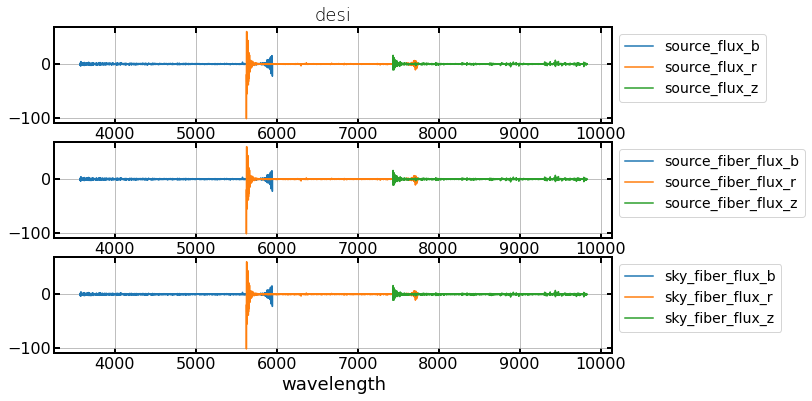

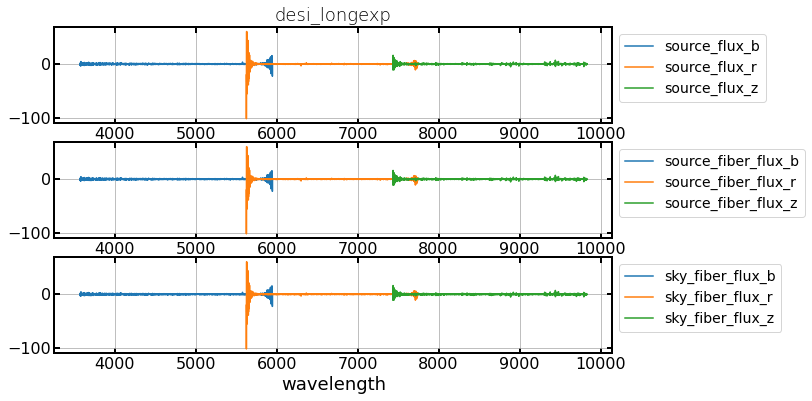

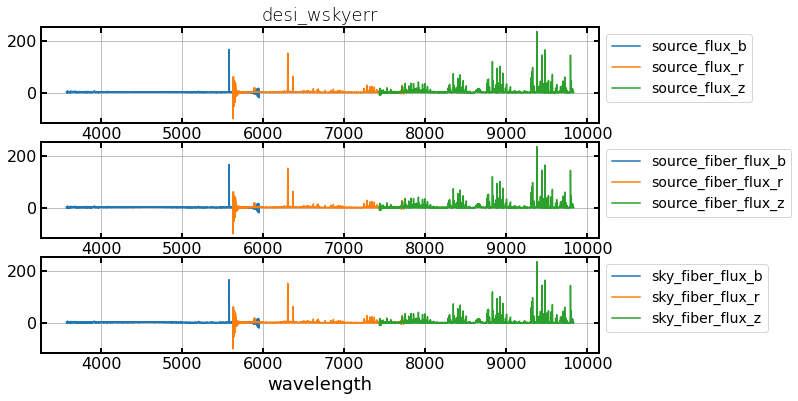

In [18]:
# now lets plot things out
for sim_name in spectra:
    fig, axes = plt.subplots(3, 1)
    for i, flux_key in enumerate(spectra[sim_name]):
        for band_key in spectra[sim_name][flux_key].flux:
            axes[i].plot(spectra[sim_name][flux_key].wave[band_key], spectra[sim_name][flux_key].flux[band_key][0, :], label=f'{flux_key}_{band_key}')
        axes[i].legend(bbox_to_anchor=(1,1))
        
    axes[0].set_title(sim_name, fontweight=10)
    axes[-1].set_xlabel('wavelength')
    
    plt.show()

why is nothing changing between the first two cases? for the last case, we see that the sky spectrum comes through.

In [19]:
#from https://github.com/olegs22/tutorial_DESI2020/blob/main/quickquasars.ipynb
from scipy.signal import medfilt

def plotspec(spectra, i, truewave=None, trueflux=None, color=['b','r','y'],nfilter=1,label=None):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), color=color[0], alpha=0.5,label=label)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), color=color[1], alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), color=color[2], alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
    ymax = np.max(spectra.flux['b'][i])
    ymin=0
    #plt.ylim(ymin, ymax+3)
    plt.ylabel('Flux')
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    return

#This will compare two spectra by dividing the first over the second
def plotspec_ratio(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]/spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]/spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]/spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This will compare two spectra by substracting the second from the first one
def plotspec_diff(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]-spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]-spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]-spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    if label!=None:
        plt.legend(loc='best')

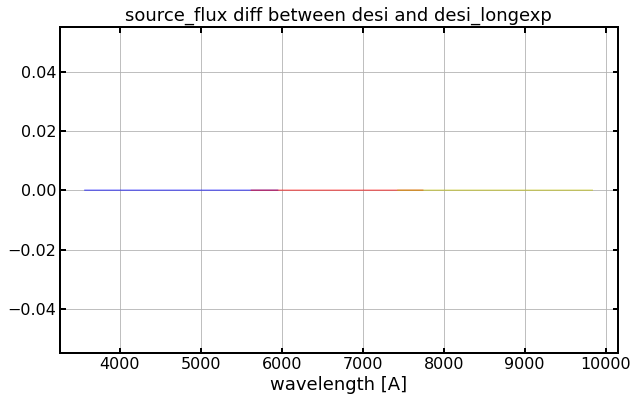

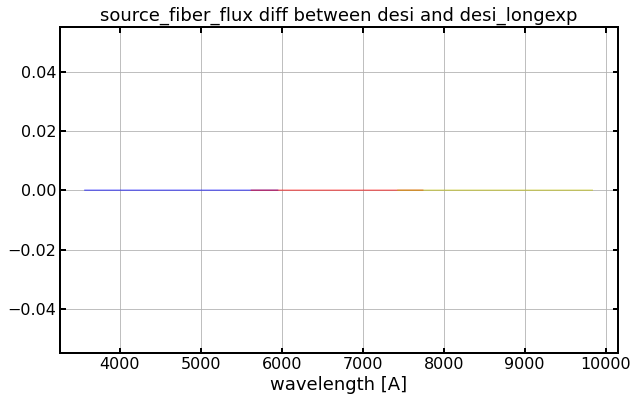

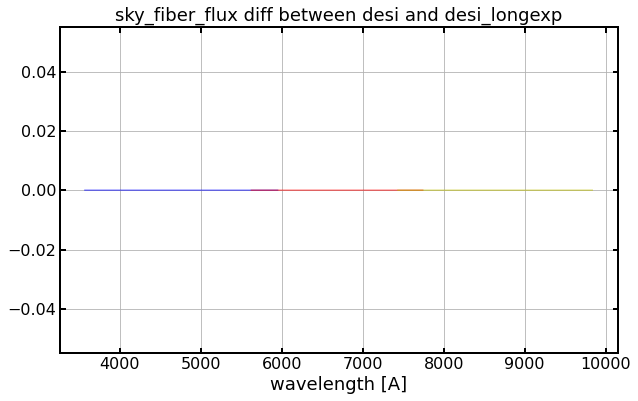

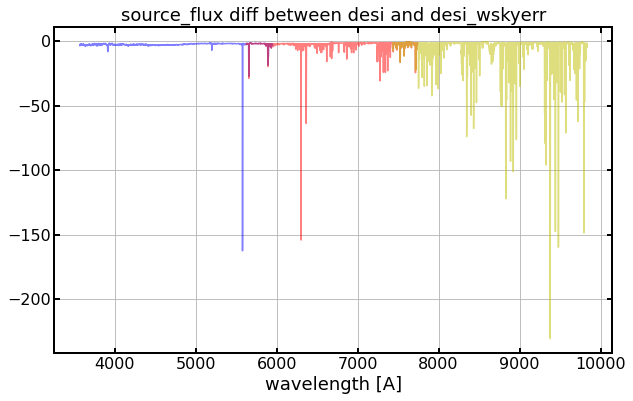

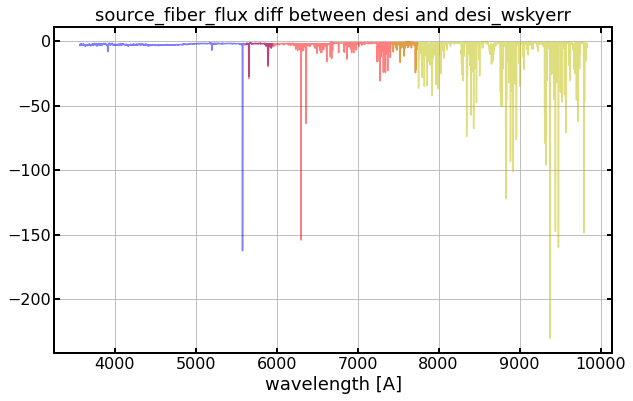

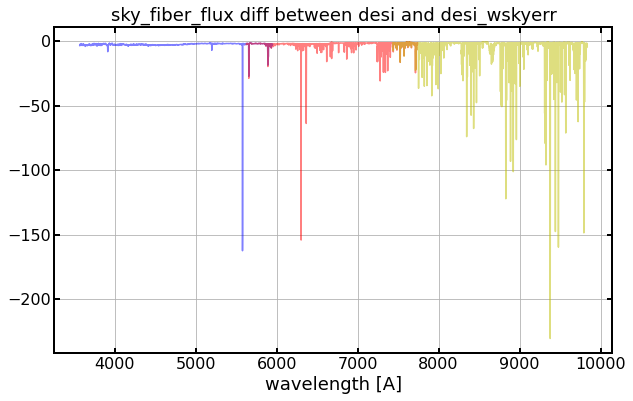

In [20]:
# plot diffs things out using the above routines
base_sim_key = 'desi'
for sim_name in ['desi_longexp', 'desi_wskyerr']:
    for flux_key in spectra[sim_name]:
        plotspec_diff(spectra1=spectra[base_sim_key][flux_key],
                      spectra2=spectra[sim_name][flux_key],
                      i=0)
        plt.title(f'{flux_key} diff between {base_sim_key} and {sim_name}')
        plt.show()

dont yet understand why the various fluxes are leading to the same spectra ..

ignore from here on

In [21]:
desi_base.camera_output

[<Table length=4760>
 wavelength ...           flux_inverse_variance [500]           
  Angstrom  ...             Angstrom2 cm4 s2 / erg2             
  float64   ...                     float64                     
 ---------- ... ------------------------------------------------
     3569.2 ... 1.0535357018043235e+33 .. 1.0452335833845433e+33
     3569.7 ... 1.0581077284683186e+33 .. 1.0497929298343133e+33
     3570.2 ... 1.0641937538222364e+33 .. 1.0558469053172176e+33
     3570.7 ... 1.0806099573285949e+33 .. 1.0720960887538101e+33
     3571.2 ...  1.1216998995368996e+33 .. 1.112688778290027e+33
     3571.7 ... 1.1764973872820883e+33 .. 1.1667882829392165e+33
     3572.2 ... 1.2094285111931232e+33 .. 1.1993130882596745e+33
     3572.7 ... 1.1984778558639658e+33 .. 1.1885744590110387e+33
     3573.2 ... 1.1639658655912232e+33 .. 1.1545948242642035e+33
        ... ...                                              ...
     5944.2 ...  2.542440245913256e+31 .. 2.3704225502194173e+31
    